**<hr>**

# <center>**PROMO TOOL**<br>prototype</center>

**<hr>**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

import sys

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

import datetime
from dateutil.parser import *

In [3]:
from sklearn.pipeline import Pipeline
from transformers import dayName, dummy_days, DFStandardScaler, ZeroFillTransformer, DFFeatureUnion

In [4]:
import pickle

<hr>

# 0. **PREPROCESSING**

## 0.1. Auxiliary functions and lists

### 0.1.1. One Hot Encoding

The function _**ohe**_ takes dataframe and encodes column (actually index) _'date'_ into 7 columns _Day names_ with binary input.

In [5]:
def ohe(self):
    self['day_of_week'] = self.index.get_level_values('date').day_name()
    encoded_columns = pd.get_dummies(self['day_of_week'])
    self = self.join(encoded_columns)
    self = self.drop('day_of_week',axis=1)
    return self

### 0.1.2. Scaling

Before calling the following function we have to provide separate dataframes for train and test data _and_ state the name of the column we want to scale. The function differs test from training data and after the scaler is fitted to train data, it transformes both training and test data. <br> <br> **Later:** improve function so it could 
* take only one dataframe as an argument 
* separate data to test and train data
* store that information 
* finally scale columns like it's described

In [6]:
def scaling_columns_seperately(self_train,self_test,col):
    aux_df = self_train[col]
    std_scaler.fit(aux_df.values.reshape(-1,1))
    aux_df = std_scaler.transform(self_train[col].values.reshape(-1,1))
    self_train[col] = aux_df
    
    aux_df = self_test[col]
    aux_df = std_scaler.transform(self_test[col].values.reshape(-1,1))
    self_test[col] = aux_df

<br>Scaling through each column for an _item_ in a for loop. <br> **Note:** self_train and self_test dataframes have same columns.<br> <br>**Later:** improve the loop (make function) so it could iterate over items (28, ..., 57) --> data is taken from df  **X**.

### 0.1.3. Handling outliers

-- outliers could be removed or set to a specific value (capping, flooring)<br> -- firstly we will _**remove**_ them

In [60]:
def removing_outliers(self):
    upper_lim = self['amount'].mean()+2*np.std(self['amount'])
    lower_lim = self['amount'].mean()-2*np.std(self['amount'])
    self=self[(self['amount'] < upper_lim) & (self['amount'] > lower_lim)]
    return self

### 0.1.4. Separating training and test data

In [8]:
def X_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux.drop('amount',axis=1)
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux.drop('amount',axis=1)
    
    return train, test

In [9]:
def y_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux['amount']
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux['amount']
    
    return train, test

### 0.1.5. Function and list initialization

In [10]:
std_scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [11]:
list_of_items = [38,39,40,41,57] 

In [12]:
rmse_train = []
rmse_test = []
r2 = []

In [13]:
categorical_features = ['day_of_week']
numerical_features = ['regular_price', 'discounted_price','number_of_stores']

## 0.2. Pipeline

Process:
   * separate dependent array _"amount"_ and _the rest of dataframe_ from the initial dataframe
   * separate data into train and test set
   * fit model on train set
   * transform both train and test set

In [14]:
pipeline = Pipeline([ ('features', DFFeatureUnion([       
                                                      ('categoricals', Pipeline([ ('dani',dayName()), ('dummyD', dummy_days())]))
                                                  ])), 
                      ('scaler', DFStandardScaler()) 
                   ])

## 0.3. Data loading

In [15]:
X = pd.read_parquet("C:/Users/vvrhovec/Veronika/kodovi/radni_folder/parquet/X_prices_stores_amount.parquet")

Napomena: srediti parquet fajlove za učitavanje svakog od artikla

In [61]:
X_38 = X.loc[38]
X_39 = X.loc[39]
X_40 = X.loc[40]
X_41 = X.loc[41]
X_57 = X.loc[57]

**<hr>**

# <center>**ITEMS**</center>

**<hr>**

# 1. ITEM 38

In [64]:
X_38.describe()

,regular_price,discounted_price,number_of_stores,amount
count,780.000000,780.000000,780.000000,780.000000
mean,0.099813,0.099813,420.452564,235.965385
std,0.001963,0.001963,21.654162,134.434059
min,0.049000,0.049000,368.000000,1.000000
25%,0.100000,0.100000,402.000000,128.750000
50%,0.100000,0.100000,420.000000,218.000000
75%,0.100000,0.100000,442.000000,335.250000
max,0.103000,0.103000,452.000000,567.000000


## 1.1. Data preprocessing

### 1.1.1. Removing outliers

In [63]:
X_38 = removing_outliers(X_38)

### 1.1.2. Separating data into training and test set

In [65]:
X_38_train, X_38_test =  X_train_test_separation(X_38)
y_38_train, y_38_test =  y_train_test_separation(X_38)

In [66]:
# X_38_train.to_parquet('X_38_train.parquet')
# X_38_test.to_parquet('X_38_test.parquet')

### 1.1.3. Pipeline

In [67]:
X_38_train = pipeline.fit_transform(X_38_train)
X_38_test = pipeline.transform(X_38_test)

In [68]:
print (X_38_train.shape, y_38_train.shape)
print (X_38_test.shape, y_38_test.shape)

(657, 10) (657,)
(123, 10) (123,)


## 1.2. Fitting and transforming

### 1.2.1. Training set

In [69]:
model_38 = lm.fit(X_38_train, y_38_train)

In [70]:
y_38_train_predicted = model_38.predict(X_38_train)

In [71]:
model_38.score(X_38_train,y_38_train)

0.1753701938409249

In [72]:
mae_38_train = mean_absolute_error(y_38_train, y_38_train_predicted)
mae_38_train

99.40166572389347

In [73]:
mse_38_train = mean_squared_error(y_38_train, y_38_train_predicted)
mse_38_train

14965.882293590717

In [74]:
rmse_38_train = np.sqrt(mean_squared_error(y_38_train, y_38_train_predicted))
rmse_train.append(rmse_38_train)
rmse_38_train

122.33512289441131

### 1.2.2. Test set

In [75]:
y_38_test_predicted = model_38.predict(X_38_test)

In [76]:
mae_38_test = mean_absolute_error(y_38_test, y_38_test_predicted)
mae_38_test

112.17810951896399

In [77]:
mse_38_test = mean_squared_error(y_38_test, y_38_test_predicted)
mse_38_test

42899.66734552031

Text(0, 0.5, 'predicted amount sold')

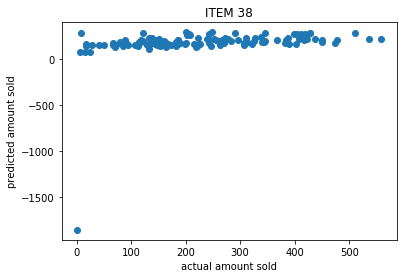

In [78]:
plt.scatter(y_38_test, y_38_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 1.3. Error metrics

In [79]:
r2_score(y_38_test,y_38_test_predicted)

-1.453645314629235

In [80]:
r2.append(r2_score(y_38_test,y_38_test_predicted))

In [81]:
rmse_38_test = np.sqrt(mean_squared_error(y_38_test, y_38_test_predicted))
rmse_test.append(rmse_38_test)
rmse_38_test

207.1223487350419

# 6. CONCLUSION

In [82]:
rmse_train

[112.7821813408887, 80.97869098095588, 122.33512289441131]

In [83]:
rmse_test

[113.86943422344577, 84.46128913673488, 207.1223487350419]

In [84]:
r2

[0.09172366773778362, 0.06658765299183955, -1.453645314629235]

--- prvi broj je rmse kada smo maknuli outliere izvan 95%
<br>--- drugi broj je kad smo maknuli sve podatke koji su od mu udaljeni više od 1 std devijacije
<br>--- treći broj je rmse kad smo maknuli podatke koji su od mu udaljeni više od 2 std devijacije  